# Wiskundige technieken les 4

Notebook bij les 4 van de leerlijn wiskundige technieken van S3 - AI. 

© Auteur: Rianne van Os

In de vorige lessen heb je alle kennis opgedaan die nodig is om het gradient descent algoritme te implementeren voor het vinden van een beste fit bij een linaire regressie. In deze gaan we toewerken naar een functie die gradient descent gebruikt om een lijn te fitten op een dataset met 1 feature- en 1 targetvariabele. 

**Voorbereiding les 4:**
- Neem de theorie en opdrachten uit de eerste 3 lessen nog eens door om je geheugen op te frissen.


In [1]:
#import benodigde libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Root mean squared error



Als eerste voorbeeld gaan we kijken naar een datasetje met maar één feature $x$ en een target $y$. We zijn dan op zoek naar de beste lijn door de punten $x$ en $y$. Hierbij is de 'beste' lijn, de lijn die zorgt voor de kleinste *root mean squared error*.

We bekijken datasetje dat we ook in de les over lineaire regressie hebben gebruikt.

In [2]:
personen = pd.DataFrame({'lengte': [1.678, 1.755, 1.764, 1.821, 1.809, 1.851, 1.848, 1.902], 
                         'gewicht': [62.2, 67.2, 72.7, 76.4, 75.2, 81.3, 87.4, 90.4]})

Nu gaan we op zoek naar een waarde $a$ en een waarde $b$ zodat we een zo goed mogelijke lijn door deze punten kunnen maken. We willen dus een $a$ en $b$ vinden, zodat bij voorkeur voor iedere $i$ geldt: 
$$gewicht_i = a \cdot lengte_i + b$$

Deze $a$ wordt ook wel de *weight* en $b$ de bias van je model genoemd. Heb je meerdere feature-variabelen, bijvoorbeeld niet alleen `lengte` maar ook `leeftijd`, dan zou je op zoek gaan naar *weights* $a_1$ en $a_2$ en een *bias* $b$, zodat $$gewicht_i = a_1 \cdot lengte_i + a_2 \cdot leeftijd_i + b.$$

Dit geval met meer features zul je later zelf moeten bekijken, we gaan in deze les uit van slechts één feature-variabele.

Als we de data plotten zien we al dat we nooit een rechte lijn zullen vinden die precies door alle punten gaat. voor $a$, de richtingscoefficent 

<Axes: xlabel='lengte', ylabel='gewicht'>

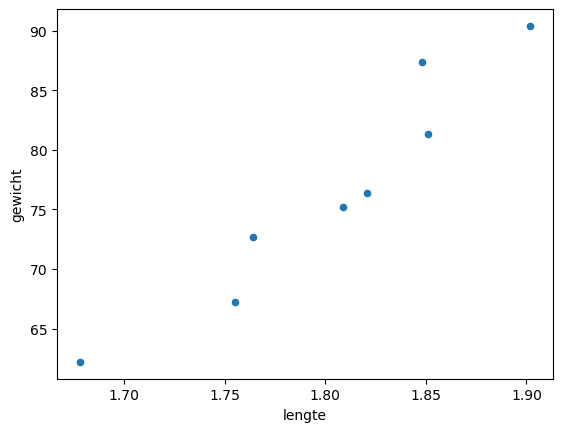

In [3]:
personen.plot.scatter('lengte','gewicht')

Om een gevoel te krijgen voor de waarde van de *weight* $a$ en *bias* $b$ gaan we eerst handmatig de formule voor een lijn opstellen door enkele punten opstellen. 

### Opdracht 4.1
a. Kies 2 observaties uit de personen dataset en stel een formule op voor de lijn die door die punten gaat.

b. Bereken de RMSE van de hele dataset, als je uitgaat van de lijn die je in a. hebt opgesteld. Dit nemen we als baseline voor je eigen implementatie van *gradient descent*. 

c. Wat is het gewicht van een persoon van 1.60m en van een persoon van 1.80m volgens de lijn die je hebt opgesteld?


Ter opfrissing: de *root mean squared error* is de wortel van de *mean squared error*, en die is gegeven door:

$ MSE = \frac{1}{n} \sum_{i = 1}^{n} (y_i - \hat{y}_i)^2$  
waarbij $\hat{y}_i$ de voorspelde waarde is. In dit 2-dimensionale geval is $\hat{y}_i = a\cdot x_i + b$.

125.89285714285717 -149.04821428571432


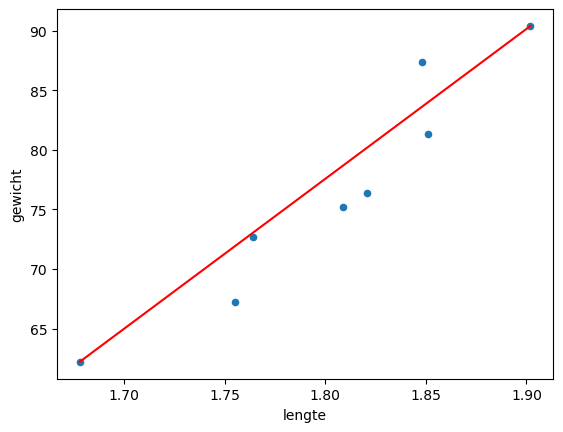

In [ ]:
# a. lijn door eerste en laatste punt --> y = ax+b
a = (personen["gewicht"][7] - personen["gewicht"][0]) / (personen["lengte"][7] - personen["lengte"][0])
b = personen["gewicht"][0] - a * personen["lengte"][0]
print(a, b)

personen.plot.scatter('lengte','gewicht')

# Compute line values
x_line = np.linspace(min(personen["lengte"]), max(personen["lengte"]), 100)
y_line = a * x_line + b

# Plot line
plt.plot(x_line, y_line, color='red', label=f'y = {a}x + {b}')
plt.show()


In [12]:
# b
y_pred = a * personen["lengte"] + b
y_true = personen["gewicht"]

rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
print(rmse)

2.9664418390238474


In [13]:
# c
gewicht1 = a * 1.6 + b
gewicht2 = a * 1.8 + b

print(gewicht1, gewicht2)

52.38035714285715 77.5589285714286


### Minimum van de RMSE vinden met gradient descent

Nu gaan we *gradient descent* implementeren om te kijken of we een betere fit kunnen vinden voor de lijn door deze dataset. Hiervoor gaan we op zoek naar het minimum van de functie van de root mean squared error. Eerder hebben je al gezien dat de root mean squared error gewoon de wortel van de mean squared error is. Als een de wortel van een functie een minimum heeft, heeft de functie zelf dat ook. Daarom is het voldoende om het minimum van de *mean squared error* te vinden, dat scheelt weer een wortel-teken die de berekeningen bemoeilijkt. De *mean squared error* ziet er zo uit:


$$ MSE = \frac{1}{n} \sum_{i = 1}^{n} (y_i - \hat{y}_i)^2$$
waarbij $\hat{y}_i = a \cdot x_i +b$, oftewel de door de regressielijn voorspelde waarde. We kunnen dit dus ook schrijven als:
$$ MSE = \frac{1}{n} \sum_{i = 1}^{n} (y_i - (a \cdot x_i +b))^2$$

En er geldt, hoe kleiner deze error, hoe beter de lijn *fit* op de data. We willen dus op zoek naar waarden $a$ en $b$ die ervoor zorgen dat de functie $$f(a,b) = \frac{1}{n} \sum_{i = 1}^{n} (y_i - (a \cdot x_i +b))^2$$ zo klein mogelijk wordt. 
**Merk op** 
- Dit is een functie met variabelen $a$ en $b$. De $x_i$ en $y_i$ zijn bekend, dit zijn namelijk de features (lengte en gewicht) uit de dataset. 

Om hier gradient descent op toe te passen, hebben we de afgeleiden $\frac{df}{da}$ en $\frac{df}{db}$ nodig. Als je direct weet hoe je die moet opstellen, mag je dat nu doen. Als je geen idee hebt, maak dan de volgende opdracht om daar stap voor stap te komen.

### Opdracht 4.2
a. We starten met het opstellen van de functie voor de MSE als we 2 datapunten hebben. Stel we hebben de punten (1.82, 76) en (1.61, 71), dan is de bijbehorende MSE te berekenen met:
$$ f(a,b) = \frac{1}{2} \left( (76 - (a \cdot 1.82 + b))^2 + (71 - (a \cdot 1.61 + b))^2 \right)$$
Bepaal van deze functie de partieel afgeleiden $\frac{df}{da}$ en $\frac{df}{db}$. 

b. We gaan nu het algemene geval met 2 datapunten bekijken, stel we hebben de datapunten $(x_1, y_1)$ en $(x_2, y_2)$, wat is dan de functie voor de MSE? En wat zijn de partieel afgeleiden?

c. Met 3 datapunten krijg je de volgende MSE:
$f (a,b) = \frac{1}{3} \left( (y_1 - (a \cdot x_1 + b))^2 + (y_2 - (a \cdot x_2 + b))^2 + (y_3 - (a \cdot x_3 + b))^2 \right)$  
wat we met een sommatie-teken kunnen schrijven als:
$$f (a,b) = \frac{1}{3} \sum_{i=1}^{3} (y_i - (a \cdot x_i + b))^2$$
Bepaal de partieel afgeleiden $\frac{df}{da}$ en $\frac{df}{db}$ van deze functie. Doe dat door eerst de functie zonder sommatie-teken te differentieren en daarna te kijken hoe je de partieel afgeleiden daarna weer met sommatie-teken kunt schrijven.

d. Probeer nu de partieel afgeleiden van de algemene functie $$f (a,b) = \frac{1}{n} \sum_{i=1}^{n} (y_i - (a \cdot x_i + b))^2$$ te vinden. 

### Opdracht 4.3

a. Implementeer *gradient descent* voor $f(a,b)$. Neem `x = personen[lengte]` en `y=personen[gewicht]` zoals hierboven. Maak gebruik van de functionaliteit van numpy om de afgeleiden te implementeren.  


b. Wat is de beste fit die je kunt vinden? Welke RMSE hoort daarbij? Welke learning rate lijkt goed te werken? Maakt het nog uit welke beginwaarde je kiest voor de *weight* en *bias*?

c. Gebruik de gevonden weight en bias (oftewel $a$ en $b$) om te bepalen wat (volgens dit model) het verwachte gewicht is van een persoon van lengte 1.80m en van een persoon met een lengte van 1.60m.

## Mogelijke verbeteringen
Hieronder benoemen we een aantal manieren om de implementatie van *gradient descent* te verbeteren. De theorie hierover kun je zelf doornemen aan de hand van de bronnen en dan proberen toe te passen in je eigen gradient descent implementatie. Voor het portfolio-item ben je verplicht 1 van deze technieken te implementeren (al hoeft het niet perse tot een verbetering van je algoritme te leiden).

### Batch gradient descent
In de implementatie van *gradient descent* die je hebt gemaakt, bereken je de afgeleiden van de *loss* functie voor alle datapunten tegelijk. Dit wordt ook wel *batch gradient descent* genoemd. Je kunt in plaats daarvan ook in iedere stap de afgeleiden berekenen voor een deel van de datapunten, dit wordt *mini-batch gradient descent* genoemd. Doe je dit in iedere stap voor 1 datapunt, dan heet het *stochastic gradient descent*.
Hier wordt dit uitgelegd: https://medium.com/data-science/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a

### Normaliseren van de data
Het kan zijn dat je algoritme sneller convergeert (dus sneller het minimum vindt) als je de data vantevoren normaliseert. Hier wordt uitgelegd waarom dat zo is: https://www.youtube.com/watch?v=to-UeYMPm34
Of lees het antwoord deze op vraag hier: https://www.quora.com/Why-is-it-important-to-scale-your-inputs-in-gradient-descent

### Learning rate decay
Het kan zijn dat je algoritme sneller convergeert (dus sneller een minimum vindt) als je de *learning rate* verlaagt naarmate je dichter bij het minimum komt. Dit heet *learning rate decay*. Hier wordt dit uitgelegd: https://www.geeksforgeeks.org/machine-learning/learning-rate-decay/
